# Comparing 3D CNN, and Vision Transformer feature extractors for Isolated Sign Language Recognition

In [5]:
from test import set_seed
import json

In [6]:
set_seed()
imp_path = 'wlasl_implemented_info.json'
runs_path = 'runs'
classes_path = 'wlasl_class_list.json'
root_path = '../data/WLASL/WLASL2000'


In [7]:
import test_claude

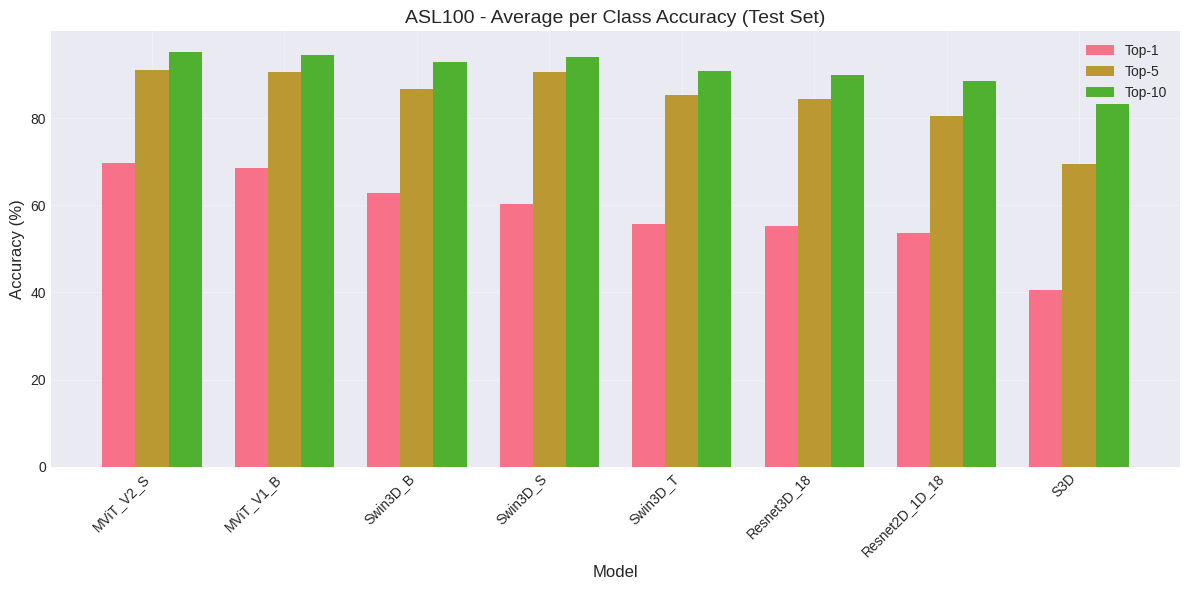

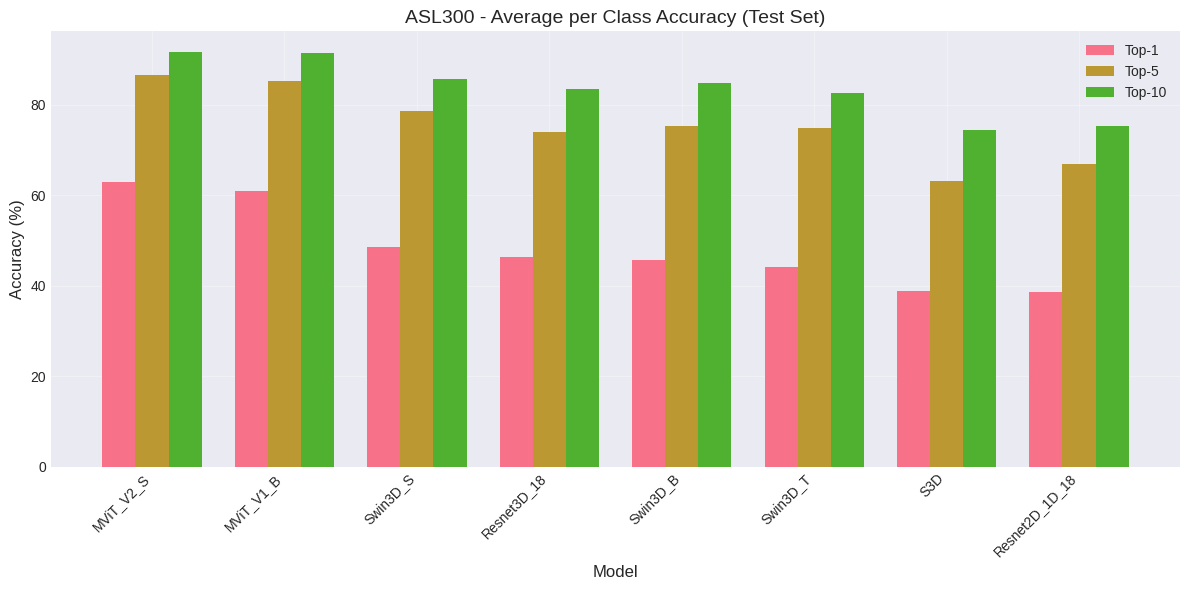

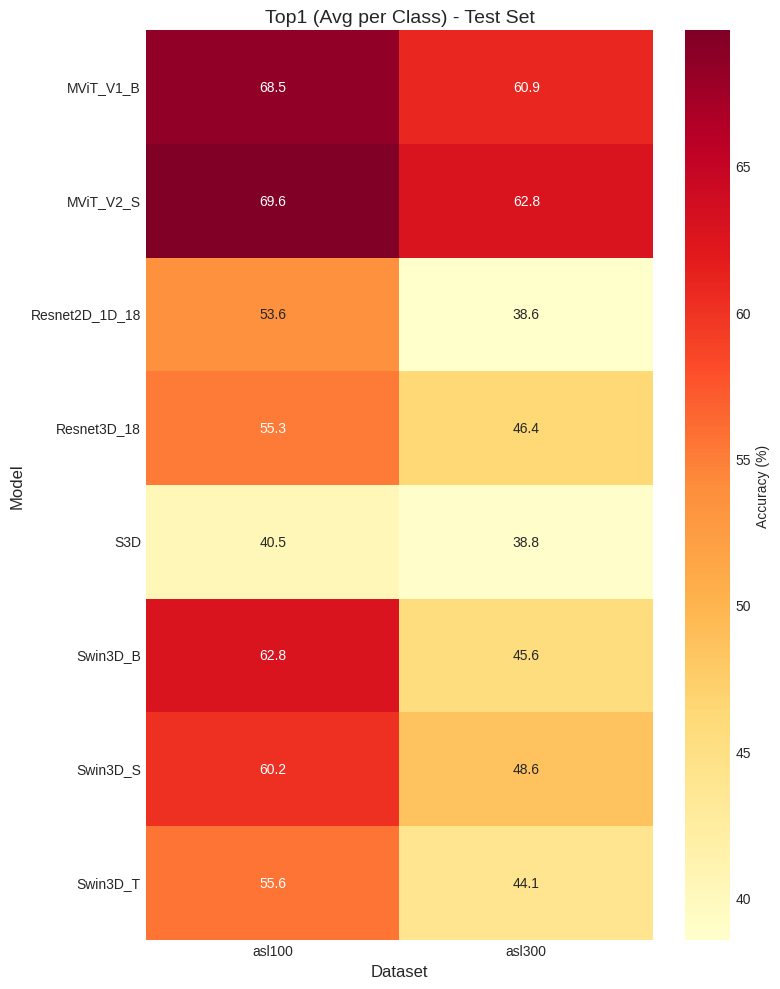

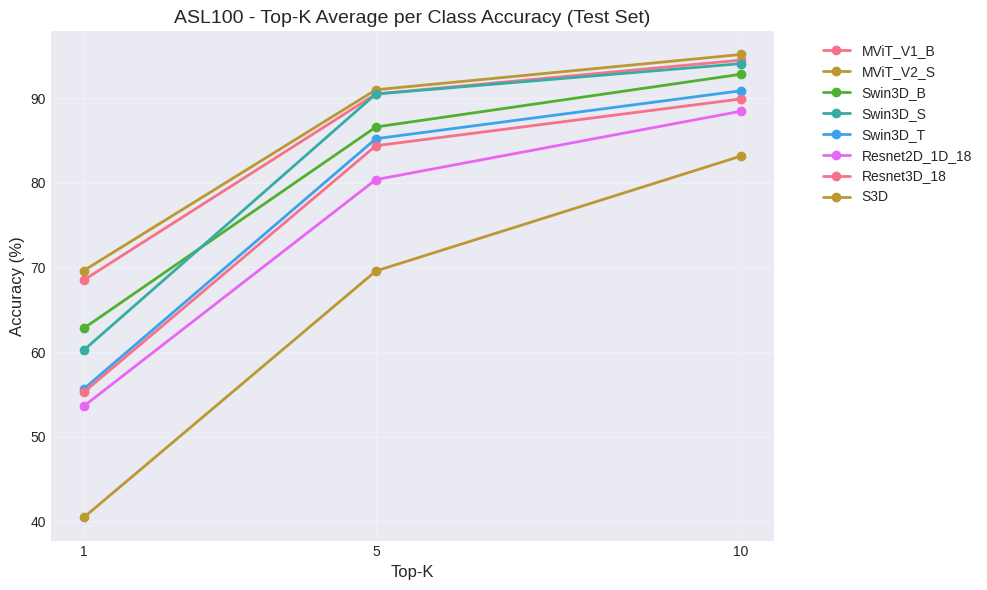

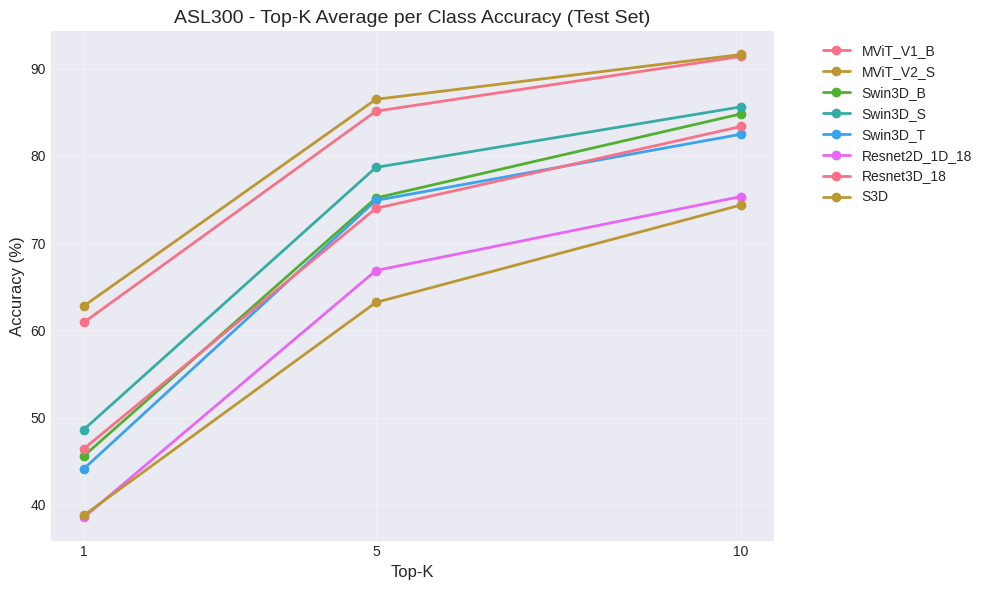

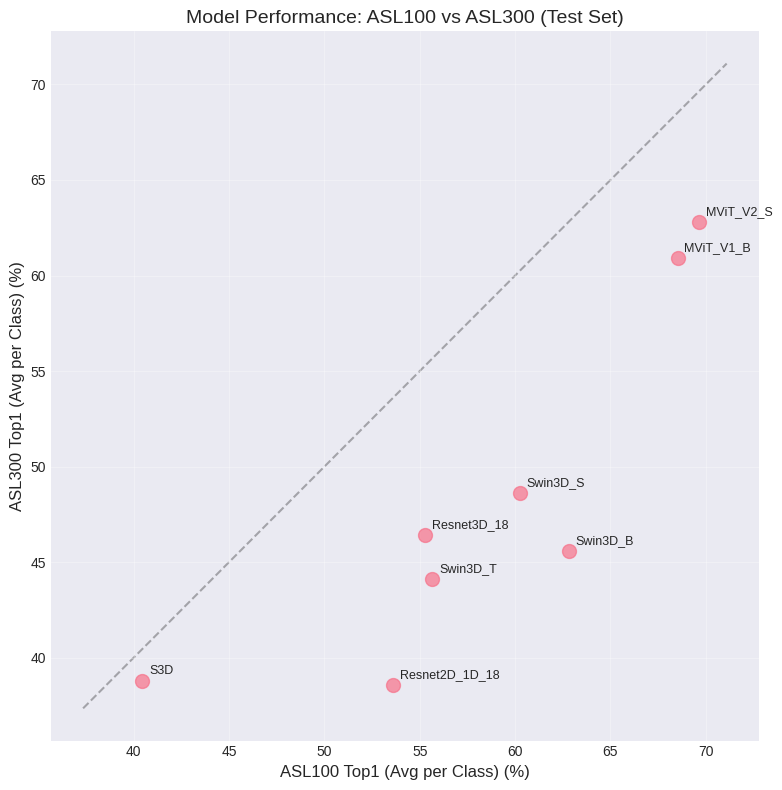

ASL100 LaTeX Table:

\begin{table}[htbp]
\centering
\caption{ASL100 Test Set Results (\% Accuracy)}
\label{tab:asl100_results}
\begin{tabular}{lcccccc}
\toprule
Model & Top-1 & Top-5 & Top-10 & Top-1 (Inst) & Top-5 (Inst) & Top-10 (Inst) \\
\midrule
MViT\_V2\_S & 69.6 & 91.0 & 95.2 & 69.0 & 90.7 & 95.0 \\
MViT\_V1\_B & 68.5 & 90.5 & 94.5 & 67.8 & 89.9 & 94.2 \\
Swin3D\_B & 62.8 & 86.6 & 92.8 & 62.8 & 86.0 & 92.6 \\
Swin3D\_S & 60.2 & 90.5 & 94.1 & 59.7 & 90.3 & 94.2 \\
Swin3D\_T & 55.6 & 85.2 & 90.9 & 55.0 & 85.3 & 90.7 \\
Resnet3D\_18 & 55.3 & 84.4 & 89.9 & 55.4 & 84.1 & 89.9 \\
Resnet2D\_1D\_18 & 53.6 & 80.4 & 88.5 & 52.7 & 79.5 & 87.6 \\
S3D & 40.5 & 69.6 & 83.2 & 41.1 & 69.8 & 82.9 \\
\bottomrule
\end{tabular}
\end{table}


ASL300 LaTeX Table:

\begin{table}[htbp]
\centering
\caption{ASL300 Test Set Results (\% Accuracy)}
\label{tab:asl300_results}
\begin{tabular}{lcccccc}
\toprule
Model & Top-1 & Top-5 & Top-10 & Top-1 (Inst) & Top-5 (Inst) & Top-10 (Inst) \\
\midrule
MViT\_V2\_S 

In [8]:
df, results = test_claude.run_visualizations('wlasl_runs_summary.json')

In [ ]:
latex_table = test_claude.generate_latex_table(
    results, 
    dataset='asl100', 
    split='test',
    metric_type='avg',  # or 'inst' or 'both'
    caption='Your Caption',
    label='tab:your_label'
)
print(latex_table)

### TODO: a plot of compute/size vs accuracy would be great if we have time